In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import tensorflow as tf
from basenji import seqnn, stream

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

2024-06-24 15:17:14.074441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 15:17:14.074493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 15:17:14.075357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 15:17:14.081030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 15:17:15.223937: W tensorflow/compiler/tf2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
from akita_utils.dna_utils import dna_1hot
from akita_utils.seq_gens import central_permutation_seqs_gen

In [4]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD,INS-16,INS-64"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False

In [5]:
# tsv with coordinates of a few example CTCF sites (range of disruption scores)
CTCT_table = "./example_disruption_scores.tsv"

In [6]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [7]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


In [8]:
chrom_sizes = "/project/fudenber_735/genomes/mm10/mm10.fa.sizes"

In [9]:
chrom_sizes_table = pd.read_csv(chrom_sizes, sep="\t", names=["chrom", "size"])

In [10]:
# chrom_sizes_table

## Loading the model

In [11]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [12]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

## Generating table with disruption parameters

In [13]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [14]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

In [15]:
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

In [16]:
seq_coords_df = seq_coords_df.copy()
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

In [25]:
# seq_coords_df.to_csv('disruption_examples.tsv', sep="\t")

In [18]:
from akita_utils.stats_utils import plot_map
from akita_utils.utils import ut_dense

In [19]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        central_permutation_seqs_gen(seq_coords_df, genome_open, chrom_sizes_table),
        batch_size,
    )

In [20]:
num_experiments = len(seq_coords_df)

In [21]:
target_index = 1

3/3 [==============================] - 13s 3s/step


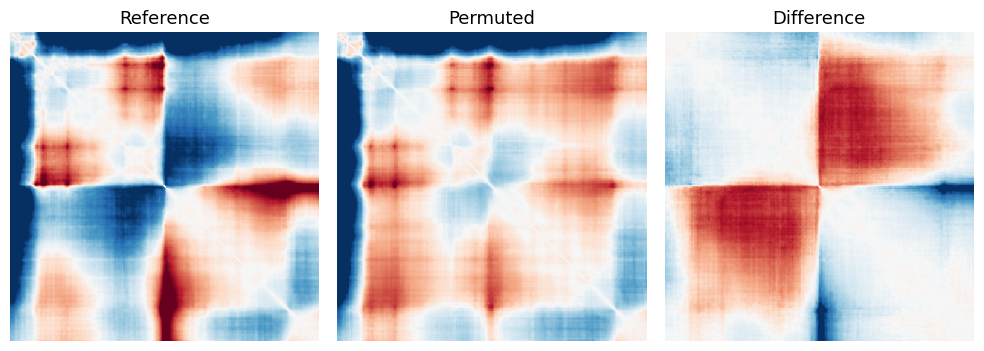

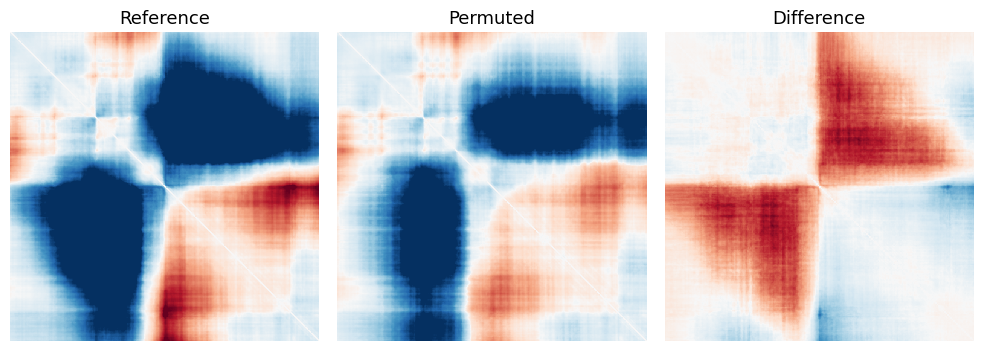

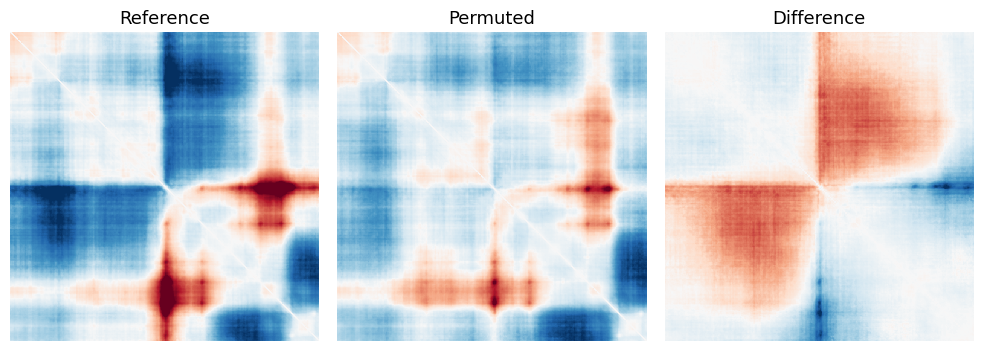

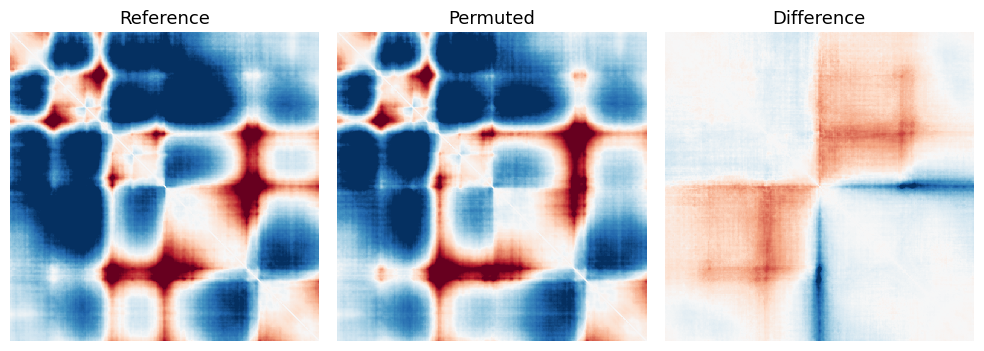

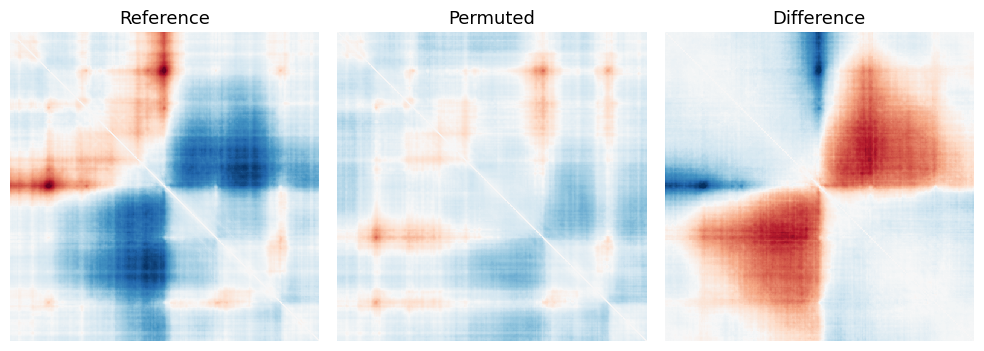

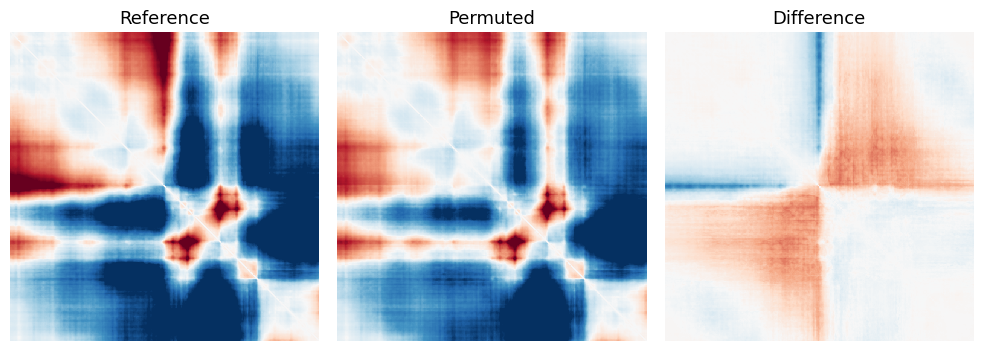

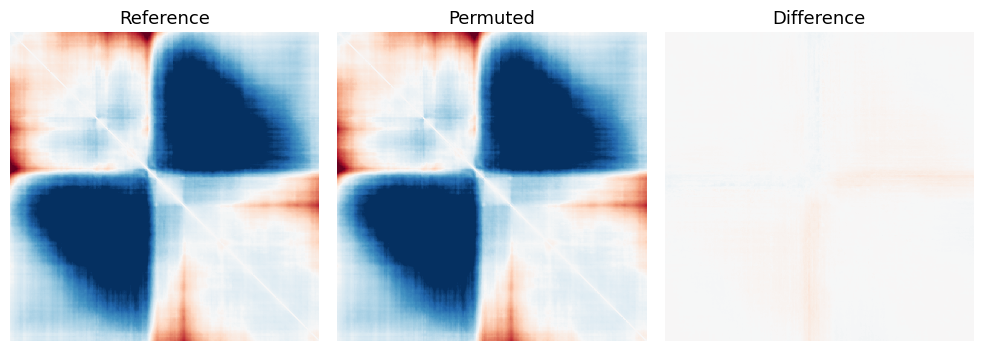

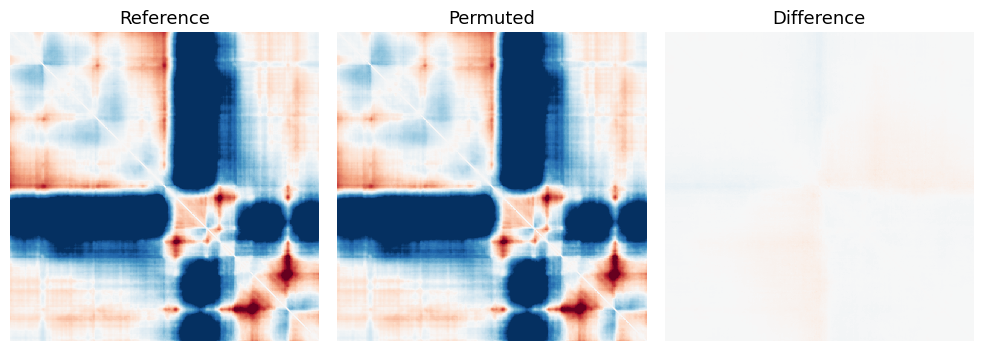

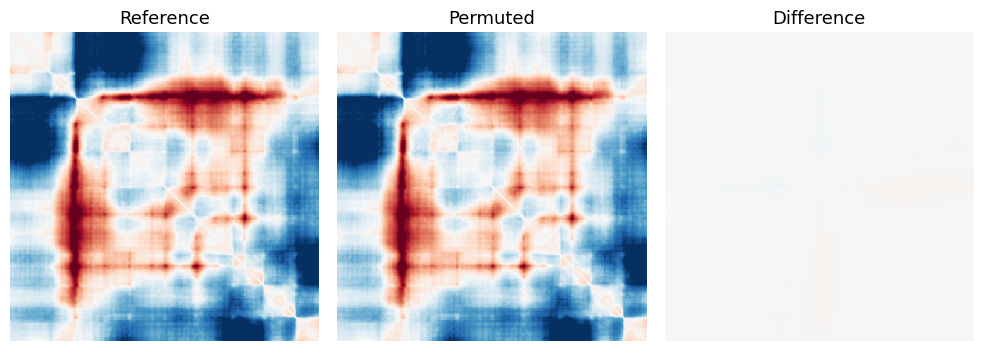

In [22]:
for ref_index in range(0, num_experiments*2, 2):
    
    ref_preds_matrix = preds_stream[ref_index]
    permut_index = ref_index + 1
    permuted_preds_matrix = preds_stream[permut_index]
    exp_index = ref_index//2

    ref_maps = ut_dense(ref_preds_matrix)
    perm_maps = ut_dense(permuted_preds_matrix)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[0]
    )
    axs[0].set_title('Reference')
    
    sns.heatmap(
        perm_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[1]
    )
    axs[1].set_title('Permuted')

    sns.heatmap(
        perm_maps[:,:,target_index]-ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[2]
    )
    axs[2].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [23]:
genome_open.close()